# ML lab 06b - Demo on Bayesian Learning using pyMC library
---

This demo showcases the usage of the library [PyMC](https://www.pymc.io/welcome.html). As they state in their page:

> PyMC is a probabilistic programming library for Python that allows users to build Bayesian models with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods.

This simple script illustrates how one would use the library to adjust a linear regression model, in particular how to compute posterior distributions for its parameters. It is very simple to substitute priors, or the likelihood function in order to build different models.

In [1]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.3.0


In [2]:
# for reproducibility
rng = np.random.default_rng(1234)

az.style.use("arviz-darkgrid")

## Generate synthetic data based on univariate _quadratic_ function with Gaussian noise

In [3]:
size = 10
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# generate y-values .. not really linear, but quadratic on x
true_regression_line = true_intercept + true_slope * x**2
# add noise
true_sigma = 0.5

y = true_regression_line + rng.normal(scale=true_sigma, size=size)

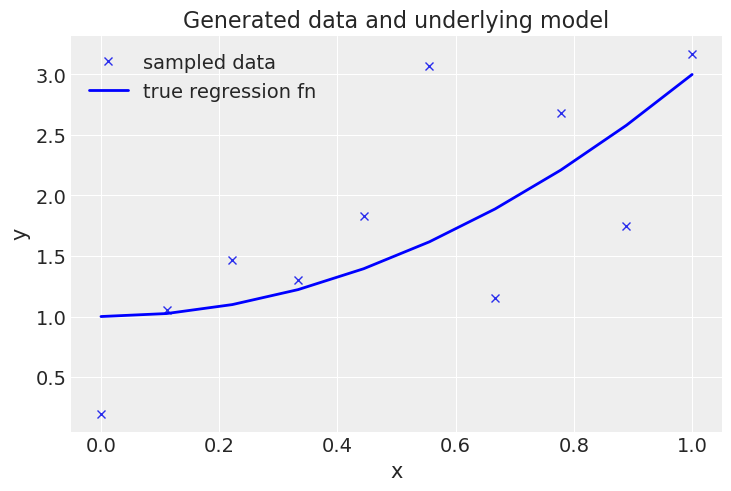

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression fn", lw=2.0, color="blue")
plt.legend(loc=0);

In [5]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=10)
    #sigma = pm.Uniform("sigma", 0.1, 5)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


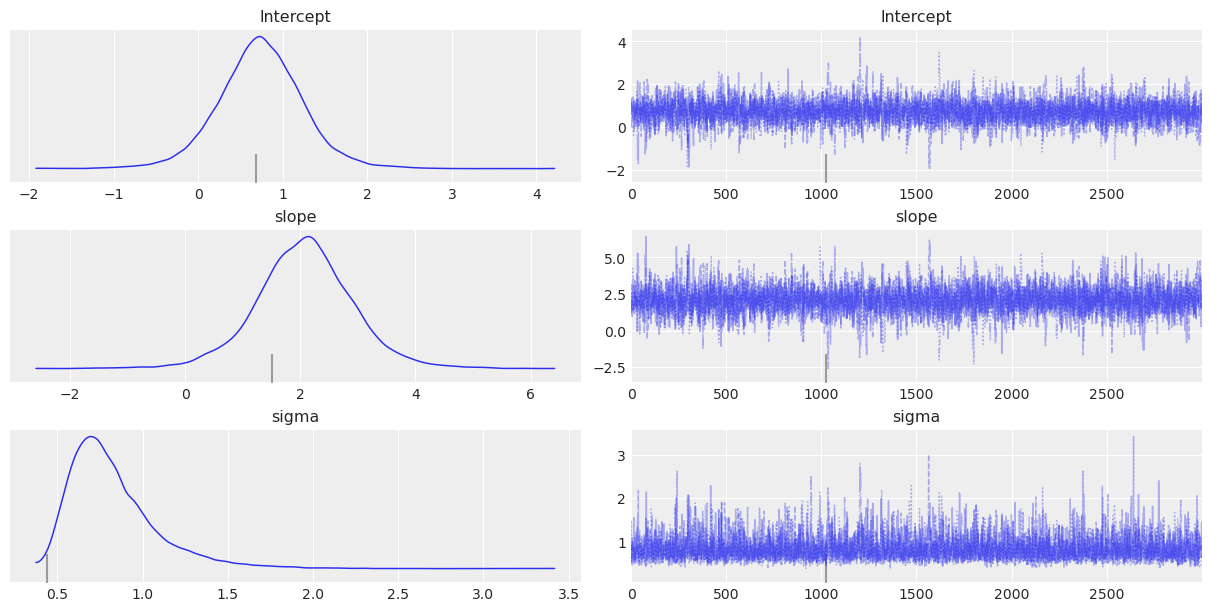

In [6]:
az.plot_trace(idata, combined=True);

In [7]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)


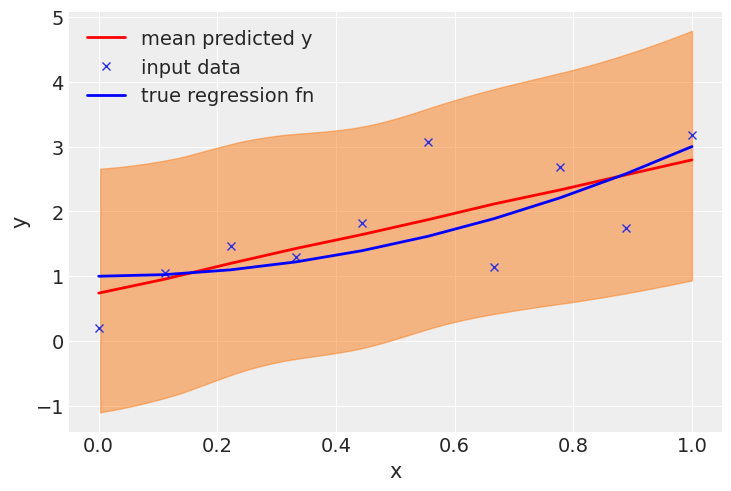

In [8]:
_, ax = plt.subplots()
ax.plot(x, idata.posterior_predictive["y"].mean(("chain", "draw")), label="mean predicted y", color="red", lw=2.0)
ax.plot(x, idata.observed_data["y"], "x", label="input data")
ax.plot(x, true_regression_line, label="true regression fn", lw=2.0, color="blue")
ax.set_xlabel("x")
az.plot_hdi(x, idata.posterior_predictive["y"])
ax.set_ylabel("y")
plt.legend(loc=0);